# Advanced Machine Learning

## Homework 2

### Exercice 1 - Imagenet

1) ImageNet is website offering collection of image datasets that are human-labeled, typically created for training models on image recognition. Each node is composed of approximately 500 images on average

2) We can find 30 synsets for 'cheese'

3) The BDAT team won the 2017 challenge, this is how they depict their Dual path networks and Basic ensemble methods: 

Adaptive attention[1] and deep combined convolutional models[2,3] are used for LOC task.

Scale[4,5,6], context[7], sampling and deep combined convolutional networks[2,3] are considered for DET task. Object density estimation is used for score re-rank. 

### Exercice 2 - Build an image recognition system

1) Importing keras module and pretrained model

In [1]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from PIL import Image
from keras.applications import InceptionV3
from keras.models       import Model
import numpy as np
from matplotlib import pyplot as mp

Using TensorFlow backend.


2) Checking architecture:

In [ ]:
model = ResNet50(weights='imagenet')
model.summary()

3) Checking single object

In [16]:
img = Image.open("dog.0.jpg")

4) Image reshaping

In [17]:
target_size = (224, 224)
img = img.resize(target_size) 
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

5) Pre-processing

In [18]:
x = preprocess_input(x)

6) Model predictions

In [19]:
preds = model.predict(x)

7) Checking results

In [20]:
decode_predictions(preds, top=5)[0]

40960/35363 [==================================] - 0s 3us/step


[('n02092002', 'Scottish_deerhound', 0.21568878),
 ('n02097298', 'Scotch_terrier', 0.15740103),
 ('n02110627', 'affenpinscher', 0.13003176),
 ('n02102318', 'cocker_spaniel', 0.077052005),
 ('n02097130', 'giant_schnauzer', 0.07410096)]

# Exercice 3 - My turn

In [3]:
from keras.applications import MobileNetV2
from keras.applications import InceptionV3
from keras.models       import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,GlobalAveragePooling2D
from keras.optimizers import Adadelta, Adagrad, Nadam, Adam, SGD
from keras.models import load_model
#from keras.applications.InceptionV3 import preprocess_input

import matplotlib.pyplot as plt

In [8]:
train_dir = "train_dir"
val_dir = "val_dir"

## Inception V3 

I'll be trying out the famous InceptionV3 neural net, first trying it by transfer learning on cats and dogs classification then by fine-tuning and finally by doing both and checking the results at each step

Inception V3 was one of the convolutional neural nets that got one of the best accruaracies in the 2012 Imagenet competition. It combines inception modules (to increase sparsity) and residual blocks (to learn deeper layers) to improve fine-tuning and detect more specific patterns

I will always proceed in the following way :
    - 1. Import and build model
    - 2. Load the data
    - 3. Train the model on the data
    - 4. Check accurarcy, generalization error etc..

### Transfer learning:

1. Build model

In [14]:
base_model=InceptionV3(weights='imagenet',include_top=False)  

In [19]:
x=base_model.output

x=GlobalAveragePooling2D()(x)
preds=Dense(2,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)

Let's have a look at the layers of InceptionV3 net

In [20]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

Since we are using transfer learning, we freeze all the layers that we've imported (they have already been trained and we decide to not re-ajust them on our data) except the two last ones for our data (310 original layers, we add two so we range on 0 to 311 to freeze). 

In [21]:
for layer in model.layers[:311]:
    layer.trainable=False
for layer in model.layers[311:]:
    layer.trainable=True

2. Loading the data

In [22]:
train_datagen=ImageDataGenerator(rescale=1./299,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./299)

train_generator  =train_datagen.flow_from_directory(train_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=30,
                                                 class_mode='categorical',
                                                 shuffle=False)

Found 251 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


3. Training the model

There are certain specificities to the InceptionV3, for example given we pass the argument include_top to False we must input and img shape of (299,299). I chose a batch size of 30 as I can allow my program to run for a certain while, and it still isn't too much compared to my train sample (251 images). Also since we're only training 2 layers, it's reasonnable to consider that amount of batches I'd say. I'll allow 5 epochs and check afterwards if allowing more might be necessary.

In [23]:
img_width, img_height = 299, 299
nb_train_samples = 251
nb_validation_samples = 61
top_epochs = 5
batch_size = 30

We will use the Adam optimizer that ressembles the rmrprop optimizer, it uses momentum as to avoid being stuck at a local minimum. I'll keep the default settings for this parameter and afterwards check if I have to modify the momentum value (by default it's 0.9) and even the learning rate. 

In [24]:
model.compile(optimizer='Nadam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size

model_InceptionV3 = model.fit_generator(
train_generator,
    steps_per_epoch = nb_train_samples / batch_size,
    epochs = top_epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples / batch_size
)

Epoch 1/5
9/8 [================================] - 528s 59s/step - loss: 0.6993 - acc: 0.6418 - val_loss: 0.3501 - val_acc: 0.8525
Epoch 2/5
9/8 [================================] - 482s 54s/step - loss: 0.3822 - acc: 0.8786 - val_loss: 0.1754 - val_acc: 1.0000
Epoch 3/5
9/8 [================================] - 498s 55s/step - loss: 0.2904 - acc: 0.9176 - val_loss: 0.1043 - val_acc: 1.0000
Epoch 4/5
9/8 [================================] - 483s 54s/step - loss: 0.2248 - acc: 0.9366 - val_loss: 0.1079 - val_acc: 0.9672
Epoch 5/5
9/8 [================================] - 490s 54s/step - loss: 0.1547 - acc: 0.9607 - val_loss: 0.0611 - val_acc: 1.0000


Now that we've got the training accuracy we need to check how good my model is in predicting a new dataset (my test split), as a very accurate model on my train set but lousy on my test set is pointless as it is equivalent to overfitting.

4. Checking accuracy

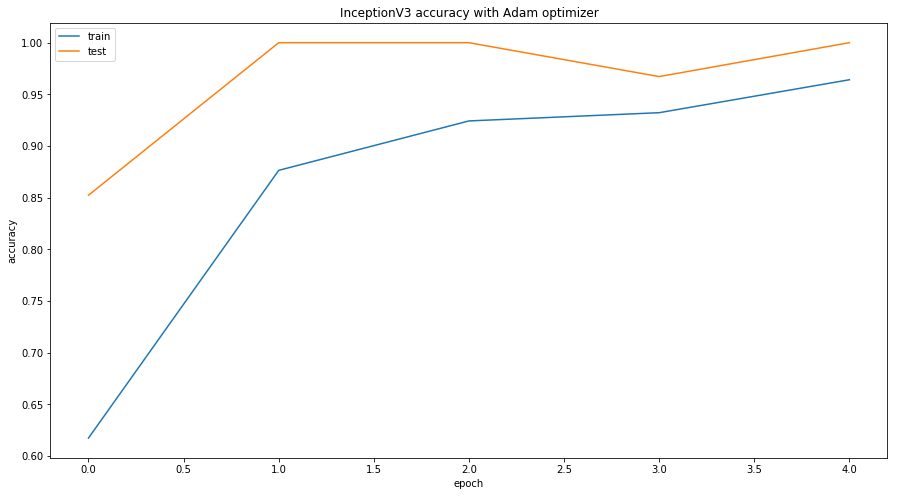

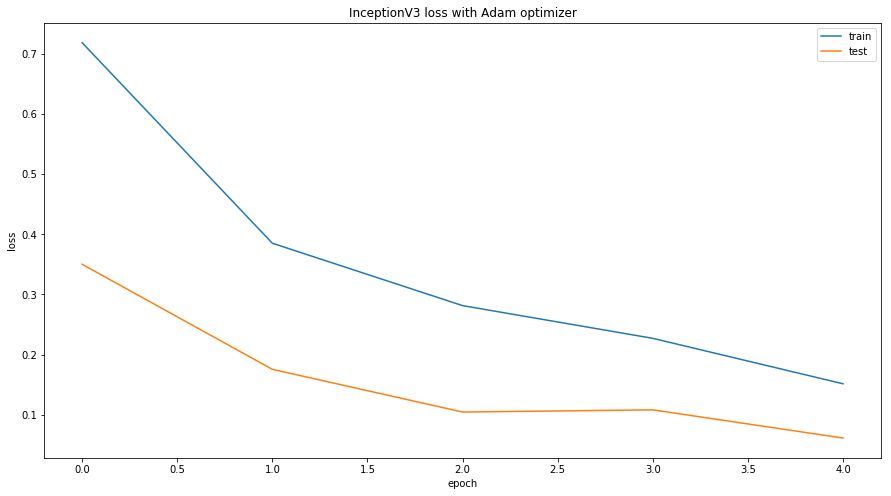

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3.history['acc'])
plt.plot(model_InceptionV3.history['val_acc'])
plt.title('InceptionV3 accuracy with Adam optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')


plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3.history['loss'])
plt.plot(model_InceptionV3.history['val_loss'])
plt.title('InceptionV3 loss with Adam optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')

mp.savefig('transfer_learning.png')

Note that even though the accuracy and loss on the test set is integrated in the model, keras doesn't access it to train wieghts. It only just calculates the generalization error as we would do normally after the training model but at each epoch.
We already obtain excellent results, where the biggest gain as at the first few epochs

Once we've finetuned our model and we're satisfied we save it:

In [52]:
model.save('V3model_transf.h5')

### Fine-tuning

Using the same model as to compare the different techniques I'll be trying out the fine tuning method, where this time I will select a subset of layers that I will unfreeze so that they train and adapt on my data. We need to re-boot the model as to not superpose trained nets. 

1. Building the model

In [28]:
base_model2=InceptionV3(weights='imagenet',include_top=False)  

In [29]:
x=base_model2.output

x=GlobalAveragePooling2D()(x)
preds=Dense(2,activation='softmax')(x) 

model2=Model(inputs=base_model2.input,outputs=preds)

I decide to unfreeze 90 layers to re-train on my image dataset, and will fine tune this untill reaching a good result

In [30]:
for layer in model2.layers[:243]:
   layer.trainable = False
for layer in model2.layers[243:]:
   layer.trainable = True

I'll try and keep similar parameters to isolate the variation in results due to the change of technique

In [31]:
img_width, img_height = 299, 299
nb_train_samples = 251
nb_validation_samples = 61
top_epochs = 5
batch_size = 40

2. Loading the data

In [32]:
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator  =train_datagen.flow_from_directory(train_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=40,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=40,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 251 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


3. Training the model

Then using SGD with a low learning rate (lr = 0.0001) we get:

In [33]:
model2.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics= ['accuracy'])

In [34]:
model_InceptionV3_2 = model2.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples / batch_size,
    epochs = top_epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples / batch_size
)

Epoch 1/5
7/6 [=================================] - 527s 75s/step - loss: 0.6719 - acc: 0.5995 - val_loss: 0.6369 - val_acc: 0.6557
Epoch 2/5
7/6 [=================================] - 453s 65s/step - loss: 0.6345 - acc: 0.6436 - val_loss: 0.5836 - val_acc: 0.7705
Epoch 3/5
7/6 [=================================] - 437s 62s/step - loss: 0.5581 - acc: 0.7517 - val_loss: 0.5329 - val_acc: 0.8689
Epoch 4/5
7/6 [=================================] - 436s 62s/step - loss: 0.5129 - acc: 0.7968 - val_loss: 0.4823 - val_acc: 0.8689
Epoch 5/5
7/6 [=================================] - 441s 63s/step - loss: 0.4590 - acc: 0.8650 - val_loss: 0.4367 - val_acc: 0.8852


4. Model assesment

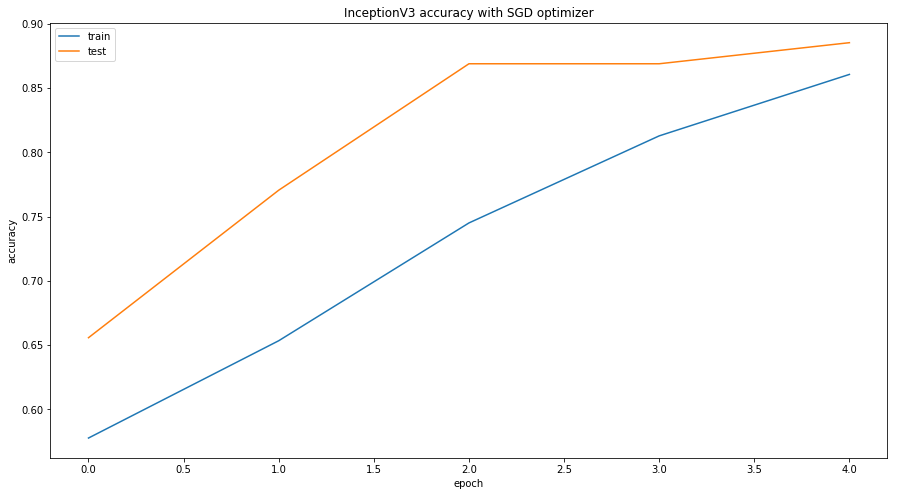

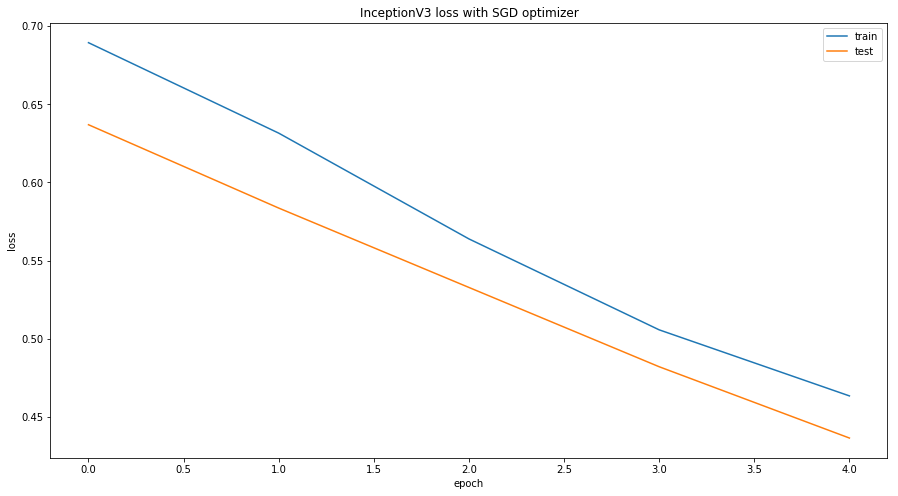

In [35]:
plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3_2.history['acc'])
plt.plot(model_InceptionV3_2.history['val_acc'])
plt.title('InceptionV3 accuracy with SGD optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')


plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3_2.history['loss'])
plt.plot(model_InceptionV3_2.history['val_loss'])
plt.title('InceptionV3 loss with SGD optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')

mp.savefig('fine_tuning.png')

We still get excellent results but they aren't as good as those obtained by fine-tuning. In the next session I'll try both of these techniques together.

In [53]:
model2.save('V3model_fine1.h5')

## Tranfer learning + fine-tuning

Now, we just need to retrieve our transfer learning model from before and fine tune it by unfreezing some layers to see the effect of the combination of both methods. 

1. Building the model

In [4]:
model = load_model("V3model_transf.h5")

In [5]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [6]:
img_width, img_height = 299, 299
nb_train_samples = 251
nb_validation_samples = 61
top_epochs = 5
batch_size = 40

2. Loading the data

In [9]:
train_datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator  =train_datagen.flow_from_directory(train_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=40,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(val_dir,
                                                 target_size=(299,299),
                                                 color_mode='rgb',
                                                 batch_size=40,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 251 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


3. Training the model

In [10]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics= ['accuracy'])

In [11]:
model_InceptionV3_3 = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples / batch_size,
    epochs = top_epochs,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples / batch_size
)

Epoch 1/5
7/6 [=================================] - 545s 78s/step - loss: 0.1399 - acc: 0.9582 - val_loss: 0.1061 - val_acc: 1.0000
Epoch 2/5
7/6 [=================================] - 500s 71s/step - loss: 0.1711 - acc: 0.9483 - val_loss: 0.1061 - val_acc: 1.0000
Epoch 3/5
7/6 [=================================] - 503s 72s/step - loss: 0.1195 - acc: 0.9819 - val_loss: 0.1016 - val_acc: 1.0000
Epoch 4/5
7/6 [=================================] - 503s 72s/step - loss: 0.1173 - acc: 0.9891 - val_loss: 0.0975 - val_acc: 1.0000
Epoch 5/5
7/6 [=================================] - 495s 71s/step - loss: 0.0967 - acc: 0.9891 - val_loss: 0.0939 - val_acc: 1.0000


4. Model assessment

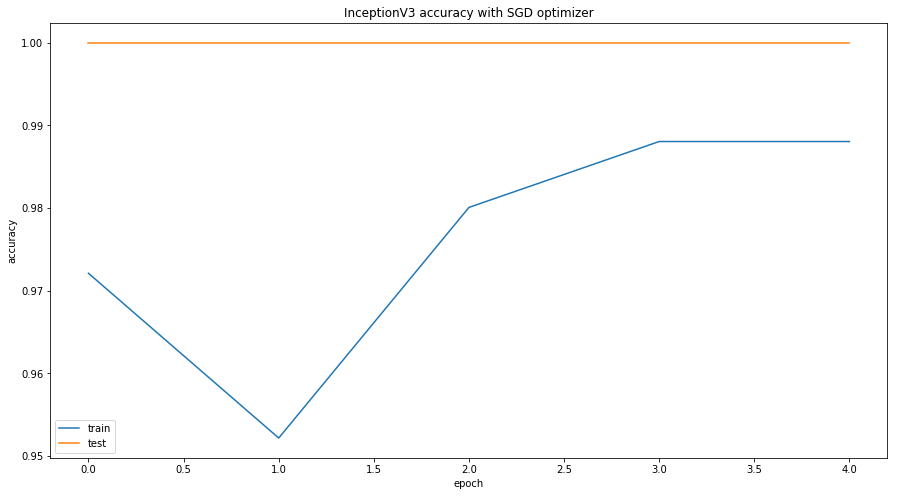

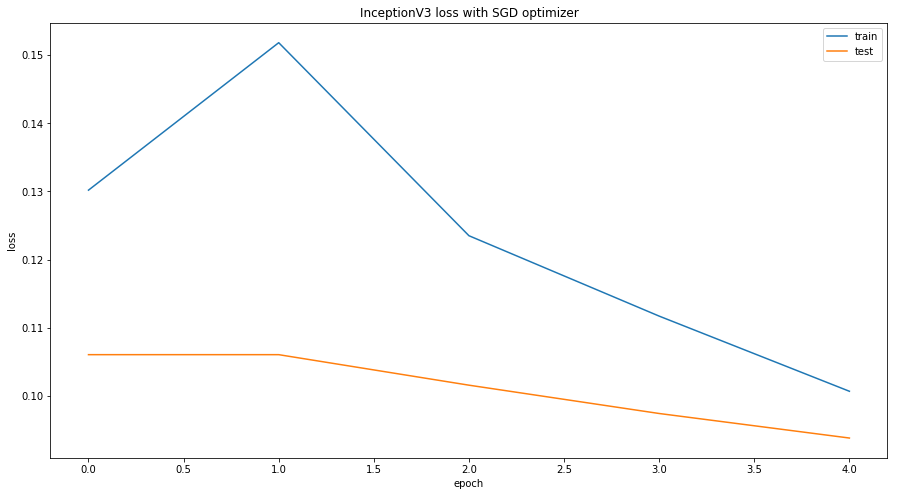

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3_3.history['acc'])
plt.plot(model_InceptionV3_3.history['val_acc'])
plt.title('InceptionV3 accuracy with SGD optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')


plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3_3.history['loss'])
plt.plot(model_InceptionV3_3.history['val_loss'])
plt.title('InceptionV3 loss with SGD optimizer')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='best')

mp.savefig('transfer_learning_+_fine_tuning.png')

When using both transfer learning and fine-tuning we get ridiculously got results, the test accuracy is at 1 even at the first epoch and stays that way at each epoch. In the same time training accuracy steadily goes up.

# OVERALL RESULTS

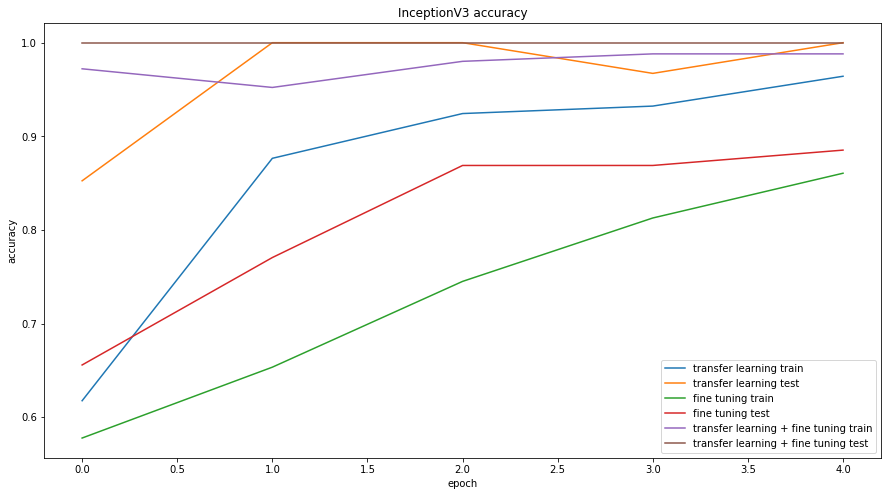

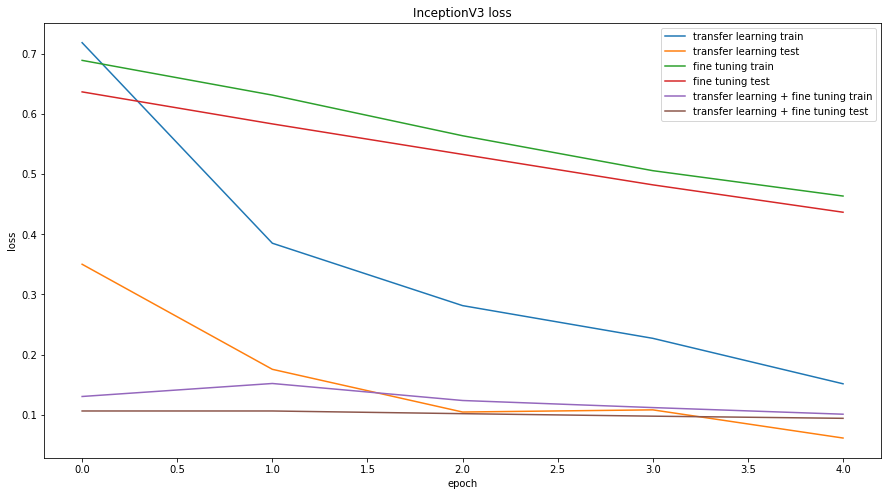

In [37]:
plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3.history['acc'])
plt.plot(model_InceptionV3.history['val_acc'])
plt.plot(model_InceptionV3_2.history['acc'])
plt.plot(model_InceptionV3_2.history['val_acc'])
plt.plot(model_InceptionV3_3.history['acc'])
plt.plot(model_InceptionV3_3.history['val_acc'])
plt.title('InceptionV3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['transfer learning train','transfer learning test',
            'fine tuning train','fine tuning test',
            'transfer learning + fine tuning train','transfer learning + fine tuning test'], loc='best')


plt.figure(figsize=(15, 8))
plt.plot(model_InceptionV3.history['loss'])
plt.plot(model_InceptionV3.history['val_loss'])
plt.plot(model_InceptionV3_2.history['loss'])
plt.plot(model_InceptionV3_2.history['val_loss'])
plt.plot(model_InceptionV3_3.history['loss'])
plt.plot(model_InceptionV3_3.history['val_loss'])
plt.title('InceptionV3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['transfer learning train','transfer learning test',
            'fine tuning train','fine tuning test',
            'transfer learning + fine tuning train','transfer learning + fine tuning test'], loc='best')

mp.savefig('overall_comparison.png')

To conclude, I would definetly recommend using both techniques together as they provide sky-rocketing results